In [2]:
# Imports and settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

pd.set_option("display.max_columns", 50)
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_context("talk")

DATA_DIR = Path("/Users/nicoletondu/Desktop/data-science-thesis-2025/data")
FILES = [
    DATA_DIR / "Journeys_2023.csv",
    DATA_DIR / "Journeys_2024_2025.csv",  # mind the space in filename
]


In [3]:
# Load data

def read_and_standardize(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    # Ensure expected columns exist
    expected = {"TravelDate", "DayOfWeek", "TubeJourneyCount", "BusJourneyCount"}
    missing = expected.difference(df.columns)
    if missing:
        raise ValueError(f"Missing columns in {path.name}: {missing}")
    # Parse date: format like 20230101
    df["date"] = pd.to_datetime(df["TravelDate"].astype(str), format="%Y%m%d", errors="coerce")
    df = df.dropna(subset=["date"]).copy()
    df["day_name"] = df["DayOfWeek"].astype("category")
    # Ensure numeric counts
    for col in ["TubeJourneyCount", "BusJourneyCount"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    return df[["date", "day_name", "TubeJourneyCount", "BusJourneyCount"]]

frames = [read_and_standardize(p) for p in FILES]
raw = pd.concat(frames, ignore_index=True).sort_values("date")
raw.head()


,date,day_name,TubeJourneyCount,BusJourneyCount
0,2023-01-01,Sunday,1494000,2149000
1,2023-01-02,Monday,1918000,2959000
2,2023-01-03,Tuesday,2255000,4227000
3,2023-01-04,Wednesday,2387000,4713000
4,2023-01-05,Thursday,2519000,4830000


In [6]:
# Basic quality checks
n_rows = len(raw)
n_missing = raw[["TubeJourneyCount", "BusJourneyCount"]].isna().sum()
summary = {
    "rows": n_rows,
    "missing_tube": int(n_missing["TubeJourneyCount"]),
    "missing_bus": int(n_missing["BusJourneyCount"]),
    "date_min": raw["date"].min(),
    "date_max": raw["date"].max(),
}
summary


{'rows': 938,
 'missing_tube': 0,
 'missing_bus': 0,
 'date_min': Timestamp('2023-01-01 00:00:00'),
 'date_max': Timestamp('2025-07-26 00:00:00')}

In [8]:
# Feature engineering
eda = raw.copy()
eda["year"] = eda["date"].dt.year
eda["month"] = eda["date"].dt.month
eda["week"] = eda["date"].dt.isocalendar().week.astype(int)
eda["dow"] = eda["date"].dt.dayofweek  # Monday=0
eda["is_weekend"] = eda["dow"].isin([5, 6])
eda["total_journeys"] = eda["TubeJourneyCount"] + eda["BusJourneyCount"]
eda.head()


,date,day_name,TubeJourneyCount,BusJourneyCount,year,month,week,dow,is_weekend,total_journeys
0,2023-01-01,Sunday,1494000,2149000,2023,1,52,6,True,3643000
1,2023-01-02,Monday,1918000,2959000,2023,1,1,0,False,4877000
2,2023-01-03,Tuesday,2255000,4227000,2023,1,1,1,False,6482000
3,2023-01-04,Wednesday,2387000,4713000,2023,1,1,2,False,7100000
4,2023-01-05,Thursday,2519000,4830000,2023,1,1,3,False,7349000


In [10]:
# Summary statistics
summary_num = eda[["TubeJourneyCount", "BusJourneyCount", "total_journeys"]].describe().T
missing_ratio = eda[["TubeJourneyCount", "BusJourneyCount"]].isna().mean().rename("missing_ratio")
pd.concat([summary_num, missing_ratio], axis=1)


,count,mean,std,min,25%,50%,75%,max,missing_ratio
TubeJourneyCount,938.0,3.165471e+06,6.083353e+05,0.0,2922000.0,3299500.0,3616750.0,4350000.0,0.0
BusJourneyCount,938.0,4.640327e+06,7.839027e+05,1000.0,4320500.0,4929500.0,5221750.0,5695000.0,0.0
total_journeys,938.0,7.805799e+06,1.351370e+06,1000.0,7314250.0,8224000.0,8838750.0,9722000.0,NaN


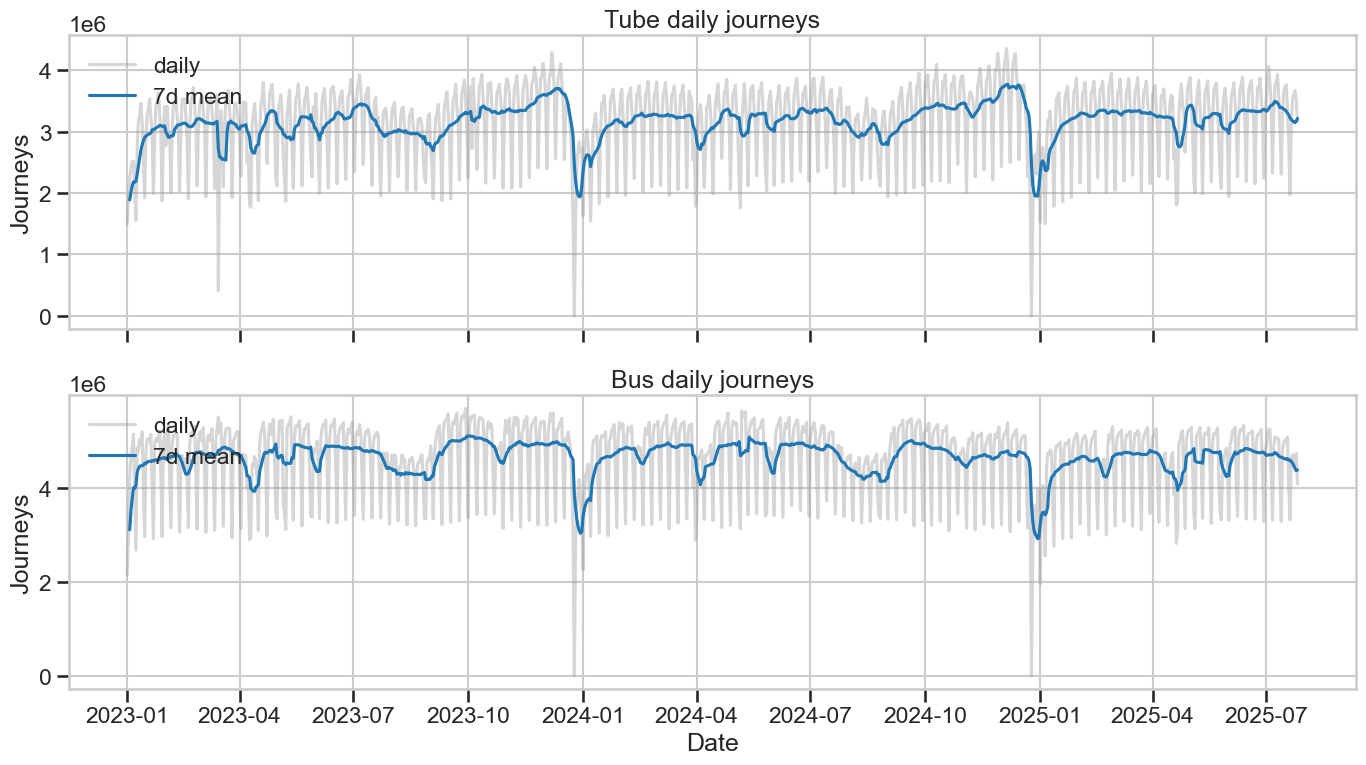

In [12]:
# Daily trends with 7-day smoothing
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
ts = eda.set_index("date").sort_index()
for ax, col, title in [
    (axes[0], "TubeJourneyCount", "Tube daily journeys"),
    (axes[1], "BusJourneyCount", "Bus daily journeys"),
]:
    ax.plot(ts.index, ts[col], color="#999999", alpha=0.4, label="daily")
    ax.plot(ts.index, ts[col].rolling(7, min_periods=3).mean(), color="#1f77b4", label="7d mean")
    ax.set_title(title)
    ax.set_ylabel("Journeys")
    ax.legend(loc="upper left")
axes[1].set_xlabel("Date")
plt.tight_layout()


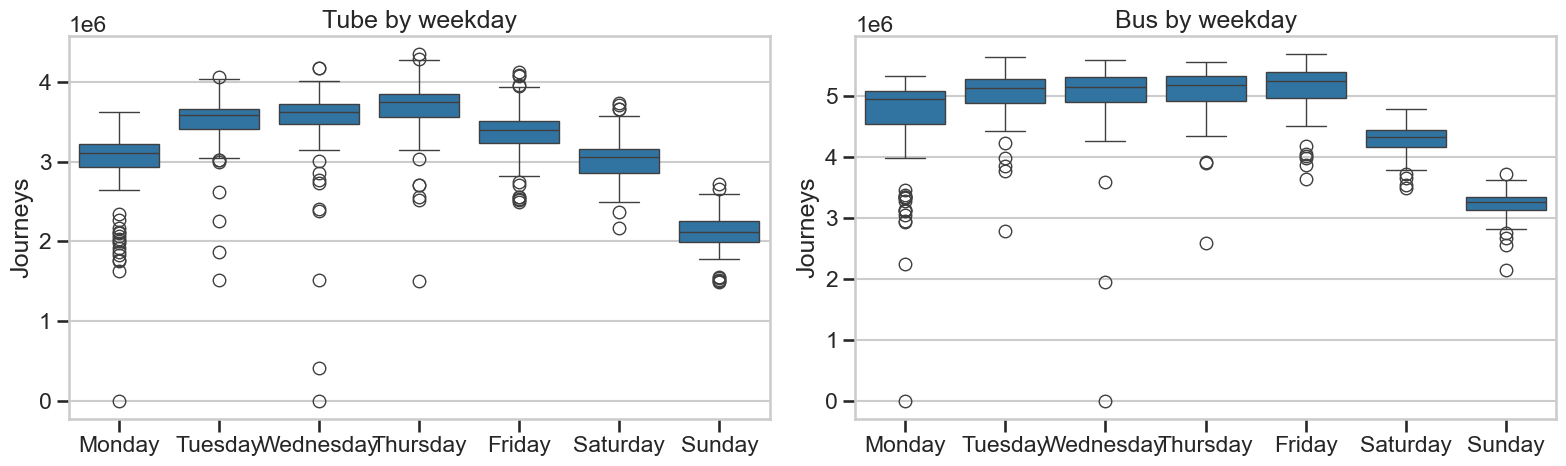

In [13]:
# Weekday patterns
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=False)
sns.boxplot(data=eda, x="day_name", y="TubeJourneyCount", order=order, ax=axes[0])
axes[0].set_title("Tube by weekday")
axes[0].set_xlabel("")
axes[0].set_ylabel("Journeys")
sns.boxplot(data=eda, x="day_name", y="BusJourneyCount", order=order, ax=axes[1])
axes[1].set_title("Bus by weekday")
axes[1].set_xlabel("")
axes[1].set_ylabel("Journeys")
plt.tight_layout()


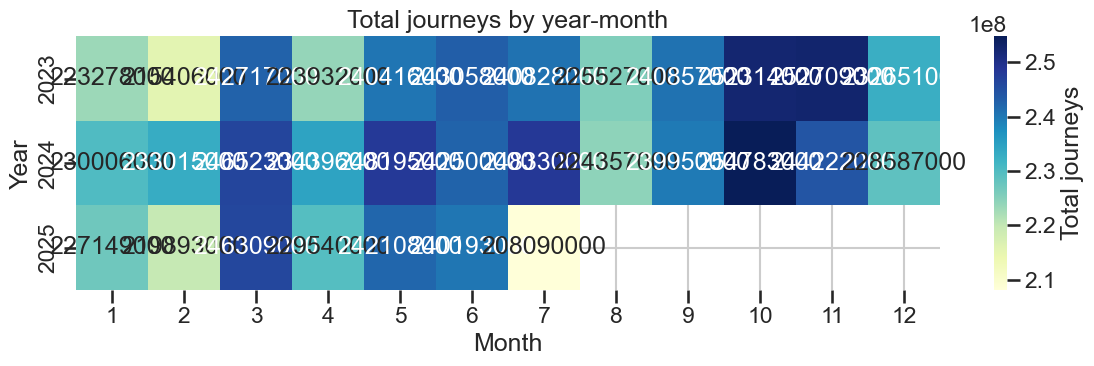

In [15]:
# Monthly totals heatmap (total journeys)
monthly = eda.groupby(["year", "month"], as_index=False)[["TubeJourneyCount", "BusJourneyCount", "total_journeys"]].sum()
pivot = monthly.pivot(index="year", columns="month", values="total_journeys").sort_index()
fig, ax = plt.subplots(figsize=(12, 4))
sns.heatmap(pivot, cmap="YlGnBu", annot=True, fmt=".0f", cbar_kws={"label": "Total journeys"})
ax.set_title("Total journeys by year-month")
ax.set_xlabel("Month")
ax.set_ylabel("Year")
plt.tight_layout()


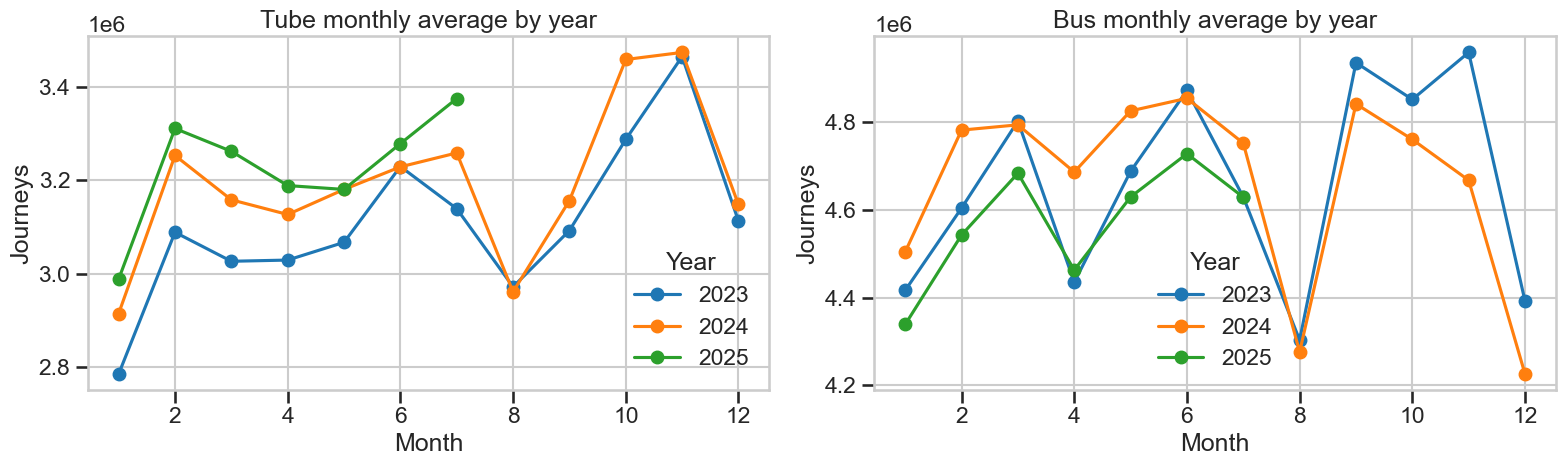

In [17]:
# Year-over-year comparison (monthly averages)
monthly_avg = eda.groupby(["year", "month"], as_index=False)[["TubeJourneyCount", "BusJourneyCount"]].mean()
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=False)
for ax, col, title in [
    (axes[0], "TubeJourneyCount", "Tube monthly average by year"),
    (axes[1], "BusJourneyCount", "Bus monthly average by year"),
]:
    for y, grp in monthly_avg.groupby("year"):
        ax.plot(grp["month"], grp[col], marker="o", label=str(y))
    ax.set_title(title)
    ax.set_xlabel("Month")
    ax.set_ylabel("Journeys")
    ax.legend(title="Year")
plt.tight_layout()


KeyError: 0

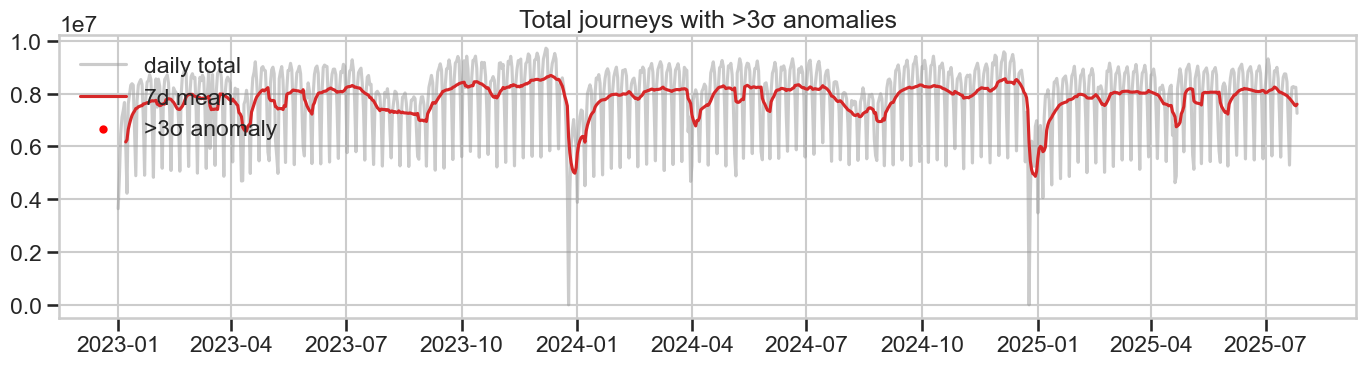

In [19]:
# Simple anomaly detection on total journeys

roll = ts["total_journeys"].rolling(7, min_periods=7)
center = roll.mean()
scale = roll.std(ddof=0)
zscore = (ts["total_journeys"] - center) / scale
anoms = zscore.abs() > 3

fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(ts.index, ts["total_journeys"], color="#999999", alpha=0.5, label="daily total")
ax.plot(ts.index, center, color="#d62728", label="7d mean")
ax.scatter(ts.index[anoms], ts.loc[anoms, "total_journeys"], color="red", s=20, label=">3σ anomaly")
ax.set_title("Total journeys with >3σ anomalies")
ax.legend(loc="upper left")
plt.tight_layout()

# Top anomalous days
anomaly_table = (
    eda.loc[anoms.reset_index(drop=False).set_index("date")[0].reindex(ts.index, fill_value=False).values,
        ["date", "day_name", "TubeJourneyCount", "BusJourneyCount", "total_journeys"]]
    .assign(zscore=zscore[anoms].values)
    .sort_values("zscore", key=np.abs, ascending=False)
    .head(15)
)
anomaly_table
